## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    - hit — взять ещё одну карту;
    - stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если
игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py


1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [111]:
import gym
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm
from collections import defaultdict
import random
random.seed(25)
np.random.seed(25)


K = 1000 # количество предыдущих эпизодов, по которому усредняем доход за эпизод для графиков

N = 100000

In [112]:
env = gym.make('Blackjack-v1', natural=True)

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [113]:
def monte_carlo(N, debug=False):
    good_points = [19, 20, 21]
    total_rewards = []
    mean_rewards = []
    for i in tqdm(range(N)):
        if debug: print(f"start game: {i}")
        observation = env.reset()
        if debug: print(observation)
        action = 0
        end_game = False
        while not end_game:
            if observation[0] in good_points:
                action = 0 # stop = 0
            else:
                action = 1 # get card = 0
            observation, reward, end_game, info = env.step(action)
            if debug: print(observation, reward, end_game)
        total_rewards.append(reward) # добавляем награды
        mean_rewards.append(np.mean(total_rewards[-K:]))
        if debug: print(f"end game: {i}")
    return total_rewards, mean_rewards
   
monte_carlo(N=2, debug=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 754.51it/s]

start game: 0
(21, 6, True)
(21, 6, True) 1.0 True
end game: 0
start game: 1
(18, 10, False)
(19, 10, False) 0.0 False
(19, 10, False) -1.0 True
end game: 1


([1.0, -1.0], [1.0, 0.0])

In [114]:
# сыграем N игр и посмотрим результаты простой стратегии
total_reward_monte_carlo, mean_reward_monte_carlo = monte_carlo(N)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:14<00:00, 6887.33it/s]


In [115]:
print(f'Количество игр: {N}')
print(f'Средний выигрыш за игру: {np.mean(total_reward_monte_carlo)}')
print(f'Средний выигрыш за игру за первые {K} игр: {mean_reward_monte_carlo[K]}')
print(f'Средний выигрыш за игру за последние {K} игр: {mean_reward_monte_carlo[-1]}')
print(f'Общий выигрыш за все игры: {np.sum(total_reward_monte_carlo)}')

Количество игр: 100000
Средний выигрыш за игру: -0.20015
Средний выигрыш за игру за первые 1000 игр: -0.225
Средний выигрыш за игру за последние 1000 игр: -0.25
Общий выигрыш за все игры: -20015.0


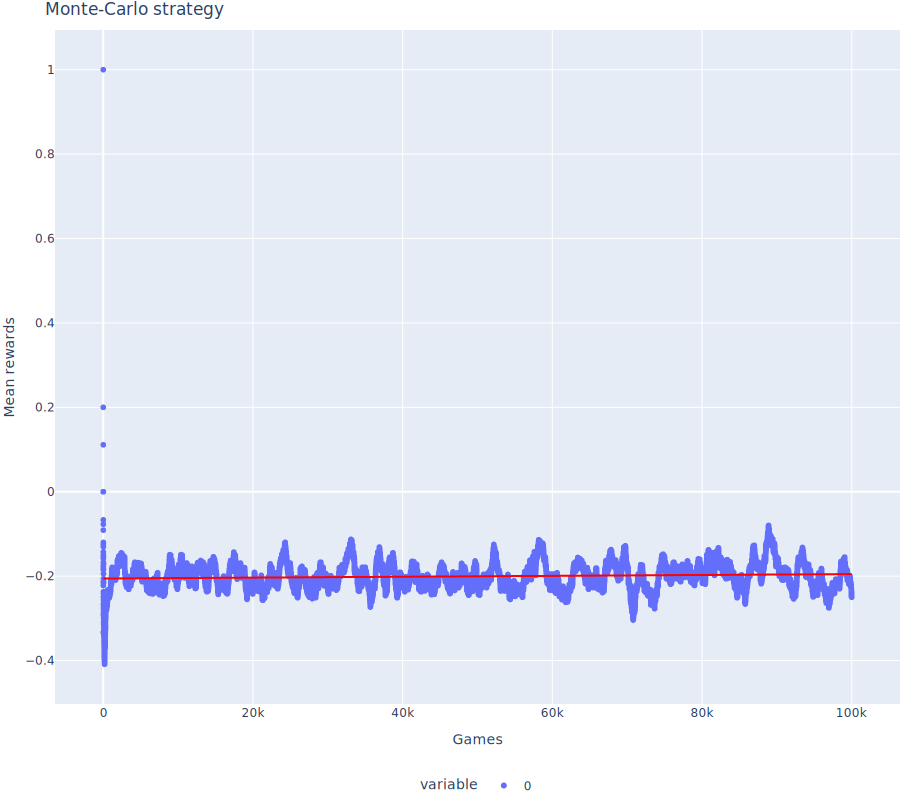

In [116]:
fig = px.scatter(mean_reward_monte_carlo, 
                 trendline="ols", 
                 trendline_color_override='red',
                )

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Monte-Carlo strategy",
                  xaxis_title="Games",
                  yaxis_title="Mean rewards",
                  margin=dict(l=0, r=0, t=30, b=0))

fig.show(renderer="svg", width=900, height=800)

**Эксперименты показали, что в среднем мы проигрываем 0.19916 за игру**

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

Будем использовать $ \epsilon $-жадную стратегию Q_learning стратегию

In [117]:
def get_states(actions=2, N=1000):
    states = set()
    for i in tqdm(range(N)):
        observation = env.reset()  # первая раздача
        states.add(observation[0])
        done = False
        while not done:
            action = np.random.randint(0, actions)
            observation, reward, done, info = env.step(action)
            states.add(observation)
        env.close()
    return list(states)  # дублированные состояния

In [118]:
A = [0, 1]  # Пространство возможных действий
S = get_states(N=100000)  # Пространство исследованных возможных состояний
print(f'|S|={len(S)}')

action_to_id = {a: i for i, a in enumerate(A)}
id_to_action = {i: a for i, a in enumerate(A)}
state_to_id = {s: i for i, s in enumerate(S)}
id_to_state = {i: s for i, s in enumerate(S)}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:08<00:00, 12114.46it/s]

|S|=398


In [119]:
def eps_greedy_Q_learning_strategy(alpha=0.1, epsilon=0.1, gamma=0.95, N=10000, debug=False, tqdm_disable=True):
    Q = np.zeros((len(S), len(A)))  # Инициализируем матрицу Q нулями
    total_rewards = []  # массив наград за все эпизоды
    mean_rewards = []  # средний доход за эпизод (усредняем по K последним раздачам) 
    for i in tqdm(range(N), disable=tqdm_disable):
        if debug: print('\nSTART_episode')
        observation = env.reset()  # первая раздача
        total_score = observation[0]  # стартовое количество очков
        state_id = state_to_id[observation[0]]
        done = False
        while not done:
            if debug: print(f'total_score={total_score}')
            # argmax с вероятностью 1-eps и случайное действие с вероятностью eps
            if np.random.rand() > epsilon:
                action_id = np.argmax(Q[state_id])
            else:
                action_id = np.random.choice(list(action_to_id.keys()))
            if debug: print(f'    action: {action_id}')
            observation, reward, done, info= env.step(id_to_action[action_id])
            total_score, _, _ = observation
            state_id_new = state_to_id[observation]
            Q[state_id, action_id] = (1 - alpha) * Q[state_id, action_id] + alpha * (reward + gamma * np.max(Q[state_id_new]))
            state_id = state_id_new
        total_rewards.append(reward)
        mean_rewards.append(np.mean(total_rewards[-K:]))
        if debug: print(f'episode_reward={reward}')
        if debug: print('END_episode\n')
        env.close()
    return total_rewards, mean_rewards, Q

In [120]:
_, _, _ = eps_greedy_Q_learning_strategy(epsilon=0.5, N=3, debug=True)


START_episode
total_score=16
    action: 1
episode_reward=-1.0
END_episode


START_episode
total_score=18
    action: 0
episode_reward=1.0
END_episode


START_episode
total_score=13
    action: 0
episode_reward=1.0
END_episode



([-1.0, 1.0, 1.0],
 [-1.0, 0.0, 0.3333333333333333],
 array([[ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. , -0.1],
        [ 0. ,  0. ],
        [ 0.1,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0.1,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
 

In [121]:
# Возьмем пока alpha=0.1, epsilon=0.1, gamma=0.95
total_reward_q, mean_reward_q, Q = eps_greedy_Q_learning_strategy(N=N)

In [122]:
print(f'Количество игр: {N}')
print(f'Средний выигрыш за игру: {np.mean(total_reward_q)}')
print(f'Средний выигрыш за игру за первые {K} игр: {total_reward_q[K]}')
print(f'Средний выигрыш за игру за последние {K} игр: {total_reward_q[-1]}')
print(f'Общий выигрыш за все игры: {np.sum(total_reward_q)}')

Количество игр: 100000
Средний выигрыш за игру: -0.17084
Средний выигрыш за игру за первые 1000 игр: 1.0
Средний выигрыш за игру за последние 1000 игр: -1.0
Общий выигрыш за все игры: -17084.0


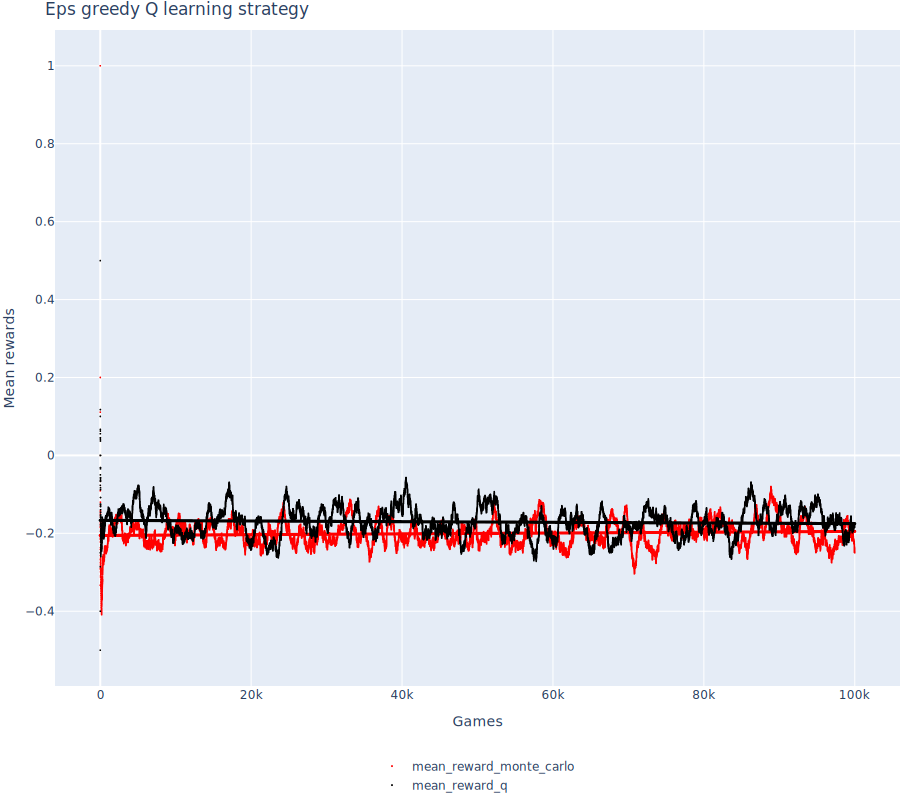

In [123]:
import plotly.graph_objects as go
import pandas as pd

fig2 = px.scatter(mean_reward_q, 
                  trendline="ols", 
                  trendline_color_override='black',
                  trendline_scope='trace', 
                  color_discrete_sequence=['black'],
                )

fig2.update_traces(mode='markers', marker_size=2)


fig1 = px.scatter(mean_reward_monte_carlo, 
                  trendline="ols", 
                  trendline_color_override='red', 
                  trendline_scope='trace',
                  color_discrete_sequence=['red'],
                )

fig1.update_traces(mode='markers', marker_size=2)


fig = go.Figure(data = fig1.data + fig2.data)

fig.update_traces(
    line=dict(dash="dot", width=4),
    selector=dict(type="scatter", mode="lines"))

line_size = 3
fig.data[1].marker.size=line_size
fig.data[3].marker.size=line_size

fig.data[0].name="mean_reward_monte_carlo"
fig.data[2].name="mean_reward_q"

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Eps greedy Q learning strategy",
                  xaxis_title="Games",
                  yaxis_title="Mean rewards",
                  margin=dict(l=0, r=0, t=30, b=0)
                 )


fig.show(renderer="svg", width=900, height=800)

**На графике выше видно, что линия тренда (то есть средний выигрыш) при $\epsilon$ жадной Q стратегии лучше (в среднем за игру проигрываем уже 0.17084**

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Попробуем подобрать оптимальные параметры $\alpha$, $\epsilon$, $\gamma$

In [124]:
# eps_greedy_Q_learning_strategy(alpha=0.1, epsilon=0.1, gamma=0.95, N=10000, debug=False):
def greed_searh_params(N=10000,
                       alphas=np.linspace(0.1, 0.9, 10), 
                       epsilons=np.linspace(0.1, 0.9, 10),
                       gammas=np.linspace(0.5, 1, 5),
                       tqdm_disable=True):
    best_reward = -1
    best_alpha = 0
    best_epsilon = 0
    best_gamma = 0
    
    alphas_epsilons_meshgrid = np.meshgrid(alphas, epsilons)
    alphas_gammas_meshgrid = np.meshgrid(alphas, gammas)
    epsilons_gammas_meshgrid = np.meshgrid(epsilons, gammas)
    
    rewards = np.zeros((len(alphas), len(epsilons),len(gammas)))
    for i, alpha in tqdm(enumerate(alphas), desc='loop0', position=0, disable=tqdm_disable):
        for j, epsilon in enumerate(epsilons):
            for k, gamma in enumerate(gammas):
                total_reward_q, mean_reward_q, Q = eps_greedy_Q_learning_strategy(N=N,
                                                                                  alpha=alpha,
                                                                                  epsilon=epsilon, 
                                                                                  gamma=gamma,
                                                                                  )
                mean_reward = np.sum(total_reward_q) / N
                rewards[i][j][k] = mean_reward
                if mean_reward > best_reward:
                    best_reward = mean_reward
                    best_alpha = (alpha, i)
                    best_epsilon = (epsilon, j)
                    best_gamma = (gamma, k)

                
    
    return best_reward, \
           best_alpha,  \
           best_epsilon, \
           best_gamma, \
           rewards, \
           alphas_epsilons_meshgrid, \
           alphas_gammas_meshgrid, \
           epsilons_gammas_meshgrid

In [188]:
best_reward, \
best_alpha, \
best_epsilon, \
best_gamma, \
rewards, \
alphas_epsilons_meshgrid, \
alphas_gammas_meshgrid, \
epsilons_gammas_meshgrid = greed_searh_params(N=10000, tqdm_disable=False)


loop0: 10it [12:15, 73.52s/it]


In [189]:
print(f"Лучший средний выигрыш: {best_reward:.5} (alpha: {best_alpha[0]:.3}, epsilon: {best_epsilon[0]:.3}, gamma: {best_gamma[0]:.3})")

Лучший средний выигрыш: -0.1574 (alpha: 0.1, epsilon: 0.1, gamma: 0.5)


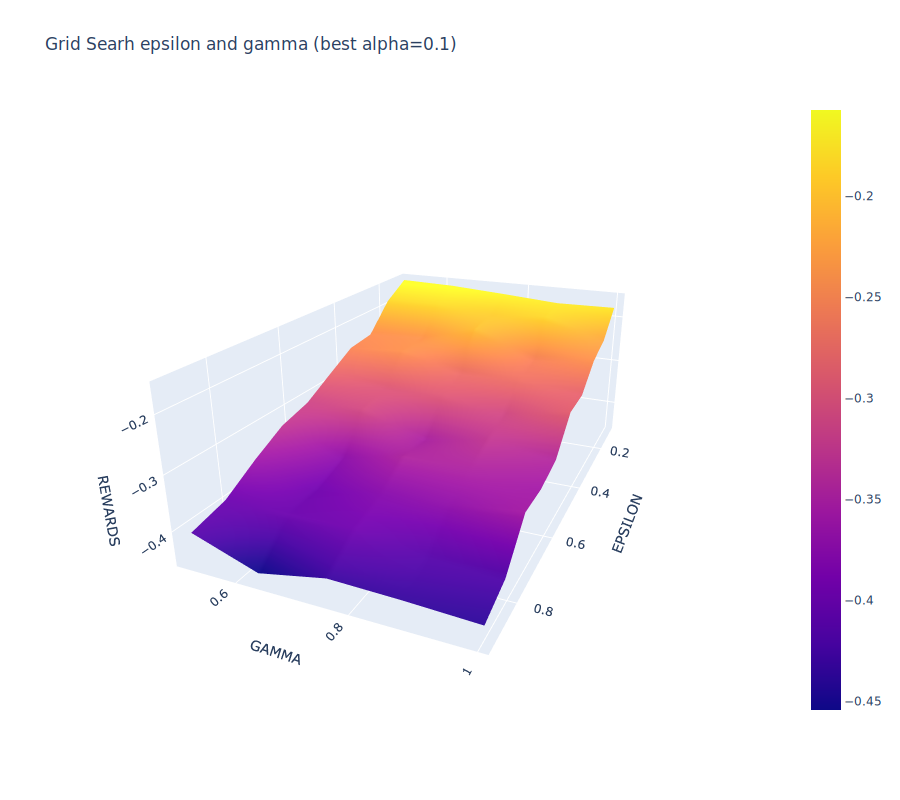

In [190]:
# При лучшем alpha
fig = 0
fig = go.Figure(data=[go.Surface(x=epsilons_gammas_meshgrid[0].T, 
                                   y=epsilons_gammas_meshgrid[1].T, 
                                   z=rewards[best_alpha[1]][:][:])])
fig.update_layout(title=f'Grid Searh epsilon and gamma (best alpha={best_alpha[0]:.3})', 
                autosize=False,  
                width=900, 
                height=800,
                scene_camera_eye=dict(x=2.3, y=1, z=1),
                  scene = dict(
                      xaxis = dict(title='EPSILON'),
                      yaxis = dict(title='GAMMA'),
                      zaxis = dict(title='REWARDS'),),
                 )
fig.show(renderer="svg")

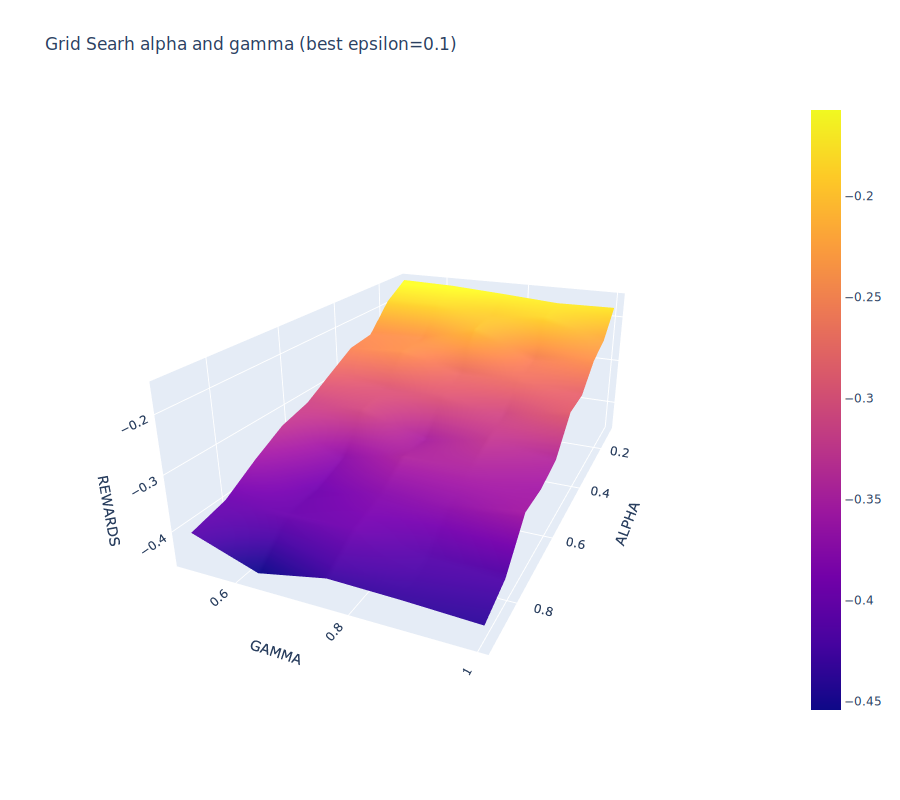

In [191]:
# При лучшем epsilon
fig = go.Figure(data=go.Surface(x=alphas_gammas_meshgrid[0].T, 
                                   y=alphas_gammas_meshgrid[1].T, 
                                   z=rewards[:][best_epsilon[1]][:]))
fig.update_layout(title=f'Grid Searh alpha and gamma (best epsilon={best_epsilon[0]:.3})', 
                autosize=False,  
                width=900, 
                height=800,
                scene_camera_eye=dict(x=2.3, y=1, z=1),
                  scene = dict(
                      xaxis = dict(title='ALPHA'),
                      yaxis = dict(title='GAMMA'),
                      zaxis = dict(title='REWARDS'),),
                 )
fig.show(renderer="svg")

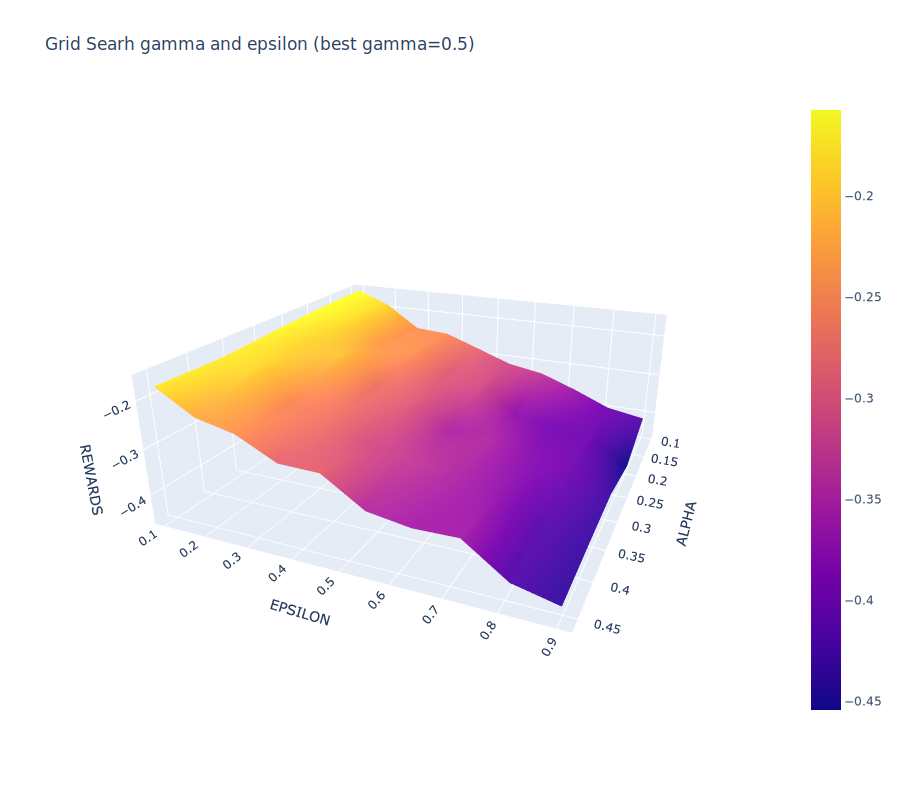

In [192]:
# При лучшем gamma
fig = go.Figure(data=go.Surface(x=alphas_epsilons_meshgrid[0], 
                                   y=alphas_epsilons_meshgrid[1], 
                                   z=rewards[:][:][best_gamma[1]]))
fig.update_layout(title=f'Grid Searh gamma and epsilon (best gamma={best_gamma[0]:.3})', 
                autosize=False,  
                width=900, 
                height=800,
                scene_camera_eye=dict(x=2.3, y=1, z=1),
                  scene = dict(
                      xaxis = dict(title='ALPHA'),
                      yaxis = dict(title='EPSILON'),
                      zaxis = dict(title='REWARDS'),),
                 )
fig.show(renderer="svg")

In [193]:
total_reward_q, mean_reward_q, Q = eps_greedy_Q_learning_strategy(N=N, alpha=best_alpha[0], epsilon=best_epsilon[0], gamma=best_gamma[0])

KeyError: 14

Лучшие найденные параметры: (alpha: 0.1, epsilon: 0.1, gamma: 0.5)
Количество игр: 100000
Средний выигрыш за игру: -0.16438
Средний выигрыш за игру за первые 1000 игр: 1.0
Средний выигрыш за игру за последние 1000 игр: -1.0
Общий выигрыш за все игры: -16438.0


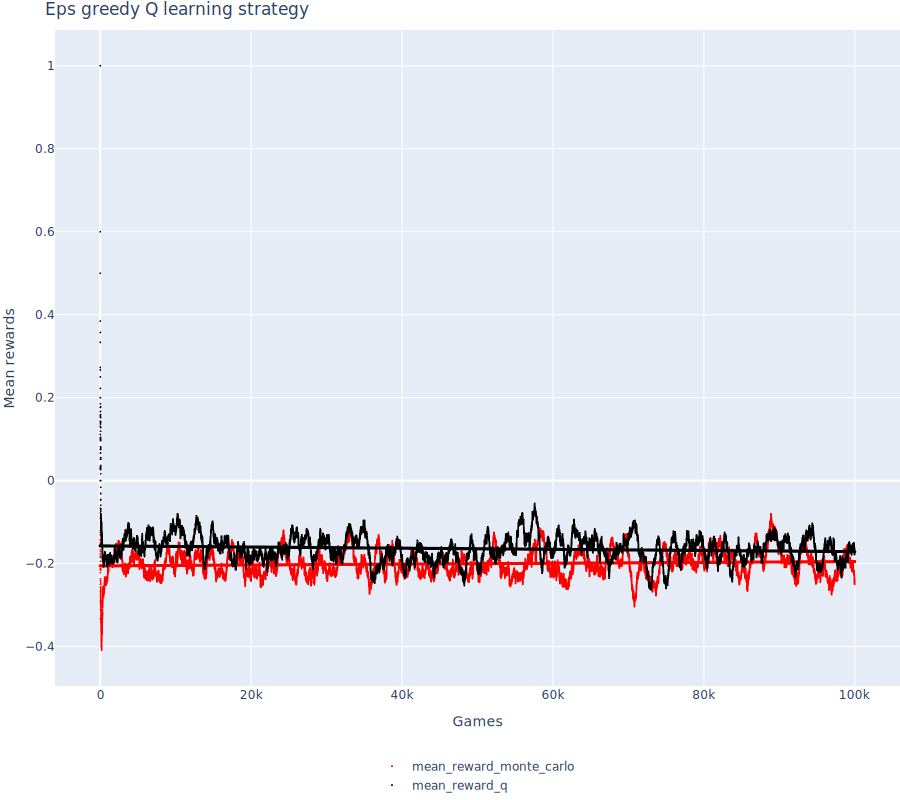

In [194]:
import plotly.graph_objects as go
import pandas as pd

fig2 = px.scatter(mean_reward_q, 
                  trendline="ols", 
                  trendline_color_override='black',
                  trendline_scope='trace', 
                  color_discrete_sequence=['black'],
                )

fig2.update_traces(mode='markers', marker_size=2)


fig1 = px.scatter(mean_reward_monte_carlo, 
                  trendline="ols", 
                  trendline_color_override='red', 
                  trendline_scope='trace',
                  color_discrete_sequence=['red'],
                )

fig1.update_traces(mode='markers', marker_size=2)


fig = go.Figure(data = fig1.data + fig2.data)

fig.update_traces(
    line=dict(dash="dot", width=4),
    selector=dict(type="scatter", mode="lines"))

line_size = 3
fig.data[1].marker.size=line_size
fig.data[3].marker.size=line_size

fig.data[0].name="mean_reward_monte_carlo"
fig.data[2].name="mean_reward_q"

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Eps greedy Q learning strategy",
                  xaxis_title="Games",
                  yaxis_title="Mean rewards",
                  margin=dict(l=0, r=0, t=30, b=0))

print(f"Лучшие найденные параметры: (alpha: {best_alpha[0]:.3}, epsilon: {best_epsilon[0]:.3}, gamma: {best_gamma[0]:.3})")

print(f'Количество игр: {N}')
print(f'Средний выигрыш за игру: {np.mean(total_reward_q)}')
print(f'Средний выигрыш за игру за первые {K} игр: {total_reward_q[K]}')
print(f'Средний выигрыш за игру за последние {K} игр: {total_reward_q[-1]}')
print(f'Общий выигрыш за все игры: {np.sum(total_reward_q)}')

fig.show(renderer="svg", width=900, height=800)

**На оптимальных параметрах проигрыш стал еще меньше (0.16438)! Но мы все еще не вышли в плюс.**

**Попробуем выйти в плюс со стратегией double**

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.



In [135]:
from blackjack_double import BlackjackDoubleEnv

env_double = BlackjackDoubleEnv(natural=True)
env_double

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [136]:
def get_states(actions=2, N=1000):
    states = set()
    for i in tqdm(range(N)):
        observation = env_double.reset()  # первая раздача
        states.add(observation[0])
        done = False
        while not done:
            action = np.random.randint(0, actions)
            observation, reward, done, info, _ = env_double.step(action)
            states.add(observation)
        env_double.close()
    return list(states)  # дублированные состояния

In [139]:
A = [0, 1, 2]  # Пространство возможных действий, 2 - это действие double
S = get_states(actions=3, N=100000)  # Пространство исследованных возможных состояний
print(f'|S|={len(S)}')

# Словари для обращения к матрице Q
action_to_id = {a: i for i, a in enumerate(A)}
id_to_action = {i: a for i, a in enumerate(A)}
state_to_id = {s: i for i, s in enumerate(S)}
id_to_state = {i: s for i, s in enumerate(S)}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:08<00:00, 12467.72it/s]

|S|=380


In [140]:
def eps_greedy_Q_learning_double_strategy(alpha=0.1, epsilon=0.1, gamma=0.95, N=10000, debug=False, tqdm_disable=True):
    Q = np.zeros((len(S), len(A)))  # Инициализируем матрицу Q нулями
    total_rewards = []
    mean_rewards = []
    for i in tqdm(range(N), disable=tqdm_disable):
        if debug: print('\nSTART_episode')
        observation = env_double.reset()  # первая раздача
        total_score = observation[0][0]  # стартовое количество очков
        state_id = state_to_id[observation[0]]
        done = False
        while not done:
            if debug: print(f'total_score={total_score}')
            # argmax с вероятностью 1-eps и случайное действие с вероятностью eps
            if np.random.rand() > epsilon:
                action_id = np.argmax(Q[state_id])
            else:
                action_id = np.random.choice(list(action_to_id.keys()))
            if debug: print(f'    action: {action_id}')
            observation, reward, done, info, _ = env_double.step(id_to_action[action_id])
            total_score, _, _ = observation
            state_id_new = state_to_id[observation]
            Q[state_id, action_id] = (1 - alpha) * Q[state_id, action_id] + alpha * (reward + gamma * np.max(Q[state_id_new]))
            state_id = state_id_new
        total_rewards.append(reward)
        mean_rewards.append(np.mean(total_rewards[-K:]))
        if debug: print(f'episode_reward={reward}')
        if debug: print('END_episode\n')
        env_double.close()
    return total_rewards, mean_rewards, Q

In [141]:
eps_greedy_Q_learning_double_strategy(epsilon=0.5, N=3, debug=True)


START_episode
total_score=9
    action: 0
episode_reward=-1.0
END_episode


START_episode
total_score=12
    action: 0
episode_reward=-1.0
END_episode


START_episode
total_score=18
    action: 0
episode_reward=1.0
END_episode



([-1.0, -1.0, 1.0],
 [-1.0, -1.0, -0.3333333333333333],
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]))

Попробуем подобрать оптимальные параметры $\alpha$, $\epsilon$, $\gamma$

In [142]:
def greed_searh_params(N=10000,
                       alphas=np.linspace(0.1, 0.9, 10), 
                       epsilons=np.linspace(0.1, 0.9, 10),
                       gammas=np.linspace(0.5, 1, 5),
                       tqdm_disable=True):
    best_reward = -1
    best_alpha = 0
    best_epsilon = 0
    best_gamma = 0
    
    alphas_epsilons_meshgrid = np.meshgrid(alphas, epsilons)
    alphas_gammas_meshgrid = np.meshgrid(alphas, gammas)
    epsilons_gammas_meshgrid = np.meshgrid(epsilons, gammas)
    
    rewards = np.zeros((len(alphas), len(epsilons),len(gammas)))
    for i, alpha in tqdm(enumerate(alphas), desc='loop0', position=0, disable=tqdm_disable):
        for j, epsilon in enumerate(epsilons):
            for k, gamma in enumerate(gammas):
                total_reward_q, mean_reward_q, Q = eps_greedy_Q_learning_double_strategy(N=N,
                                                                                  alpha=alpha,
                                                                                  epsilon=epsilon, 
                                                                                  gamma=gamma,
                                                                                  )
                mean_reward = np.sum(total_reward_q) / N
                rewards[i][j][k] = mean_reward
                if mean_reward > best_reward:
                    best_reward = mean_reward
                    best_alpha = (alpha, i)
                    best_epsilon = (epsilon, j)
                    best_gamma = (gamma, k)

                
    
    return best_reward, \
           best_alpha,  \
           best_epsilon, \
           best_gamma, \
           rewards, \
           alphas_epsilons_meshgrid, \
           alphas_gammas_meshgrid, \
           epsilons_gammas_meshgrid

In [143]:
best_reward, \
best_alpha, \
best_epsilon, \
best_gamma, \
rewards, \
alphas_epsilons_meshgrid, \
alphas_gammas_meshgrid, \
epsilons_gammas_meshgrid = greed_searh_params(N=10000, tqdm_disable=False)

loop0: 10it [12:16, 73.60s/it]


In [144]:
print(f"Лучший средний выигрыш: {best_reward:.5} (alpha: {best_alpha[0]:.3}, epsilon: {best_epsilon[0]:.3}, gamma: {best_gamma[0]:.3})")

Лучший средний выигрыш: -0.14545 (alpha: 0.1, epsilon: 0.1, gamma: 0.5)


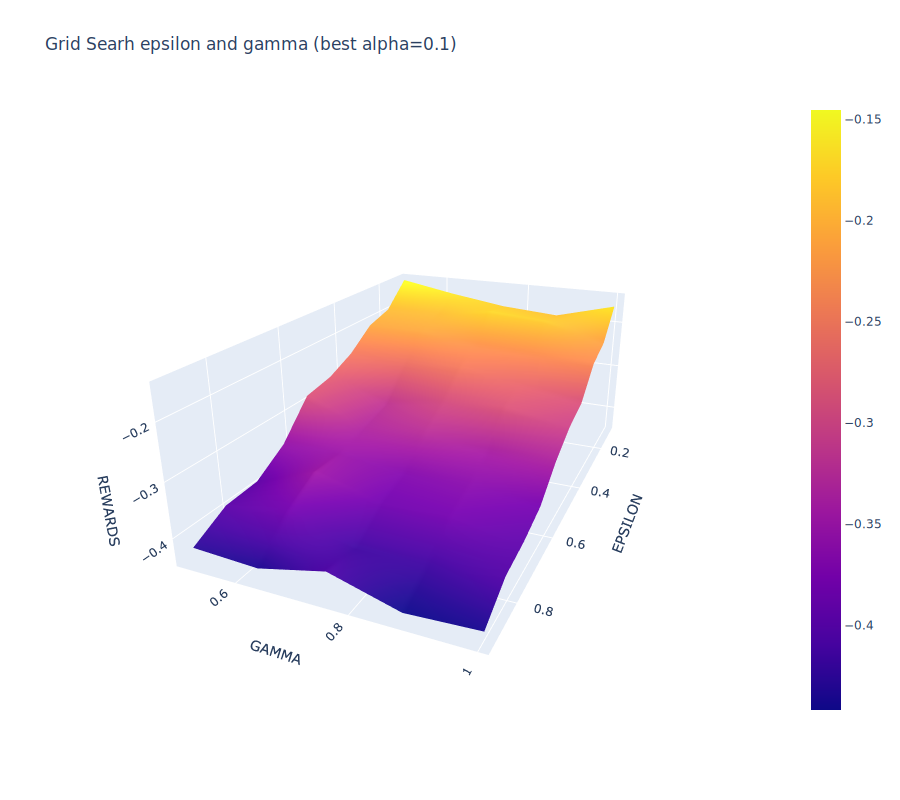

In [174]:
# При лучшем alpha
fig = 0
fig = go.Figure(data=[go.Surface(x=epsilons_gammas_meshgrid[0].T, 
                                   y=epsilons_gammas_meshgrid[1].T, 
                                   z=rewards[best_alpha[1]][:][:])])
fig.update_layout(title=f'Grid Searh epsilon and gamma (best alpha={best_alpha[0]:.3})', 
                autosize=False,  
                width=900, 
                height=800,
                scene_camera_eye=dict(x=2.3, y=1, z=1),
                scene = dict(
                      xaxis = dict(title='EPSILON'),
                      yaxis = dict(title='GAMMA'),
                      zaxis = dict(title='REWARDS'),),
                )
fig.show(renderer="svg")

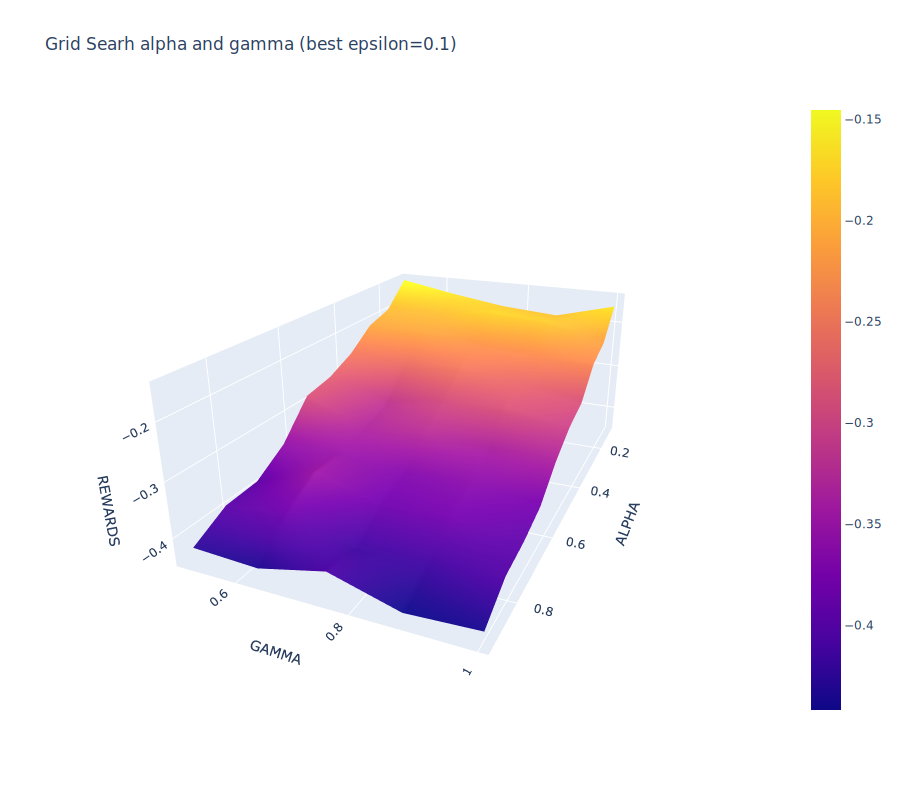

In [176]:
# При лучшем epsilon
fig = go.Figure(data=go.Surface(x=alphas_gammas_meshgrid[0].T, 
                                   y=alphas_gammas_meshgrid[1].T, 
                                   z=rewards[:][best_epsilon[1]][:]))
fig.update_layout(title=f'Grid Searh alpha and gamma (best epsilon={best_epsilon[0]:.3})', 
                autosize=False,  
                width=900, 
                height=800,
                scene_camera_eye=dict(x=2.3, y=1, z=1),
                  scene = dict(
                      xaxis = dict(title='ALPHA'),
                      yaxis = dict(title='GAMMA'),
                      zaxis = dict(title='REWARDS'),),
                 )
fig.show(renderer="svg")

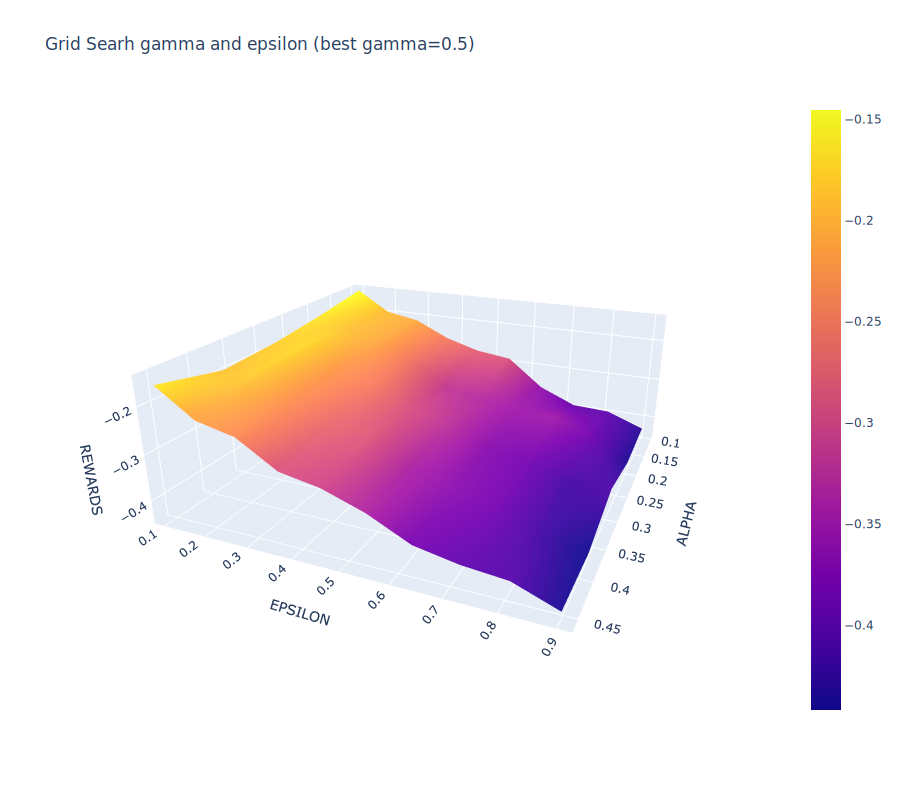

In [177]:
# При лучшем gamma
fig = go.Figure(data=go.Surface(x=alphas_epsilons_meshgrid[0], 
                                   y=alphas_epsilons_meshgrid[1], 
                                   z=rewards[:][:][best_gamma[1]]))
fig.update_layout(title=f'Grid Searh gamma and epsilon (best gamma={best_gamma[0]:.3})', 
                autosize=False,  
                width=900, 
                height=800,
                scene_camera_eye=dict(x=2.3, y=1, z=1),
                  scene = dict(
                      xaxis = dict(title='ALPHA'),
                      yaxis = dict(title='EPSILON'),
                      zaxis = dict(title='REWARDS'),),
                 )
fig.show(renderer="svg")

Обучим на оптимальных параметрах и сравним результаты

In [179]:
total_reward_q_double, mean_reward_q_double, Q_double = eps_greedy_Q_learning_double_strategy(N=N, alpha=best_alpha[0], epsilon=best_epsilon[0], gamma=best_gamma[0])

Лучшие найденные параметры: (alpha: 0.1, epsilon: 0.1, gamma: 0.5)
Количество игр: 100000
Средний выигрыш за игру: -0.138915
Средний выигрыш за игру за первые 1000 игр: -1.0
Средний выигрыш за игру за последние 1000 игр: 1.5
Общий выигрыш за все игры: -13891.5


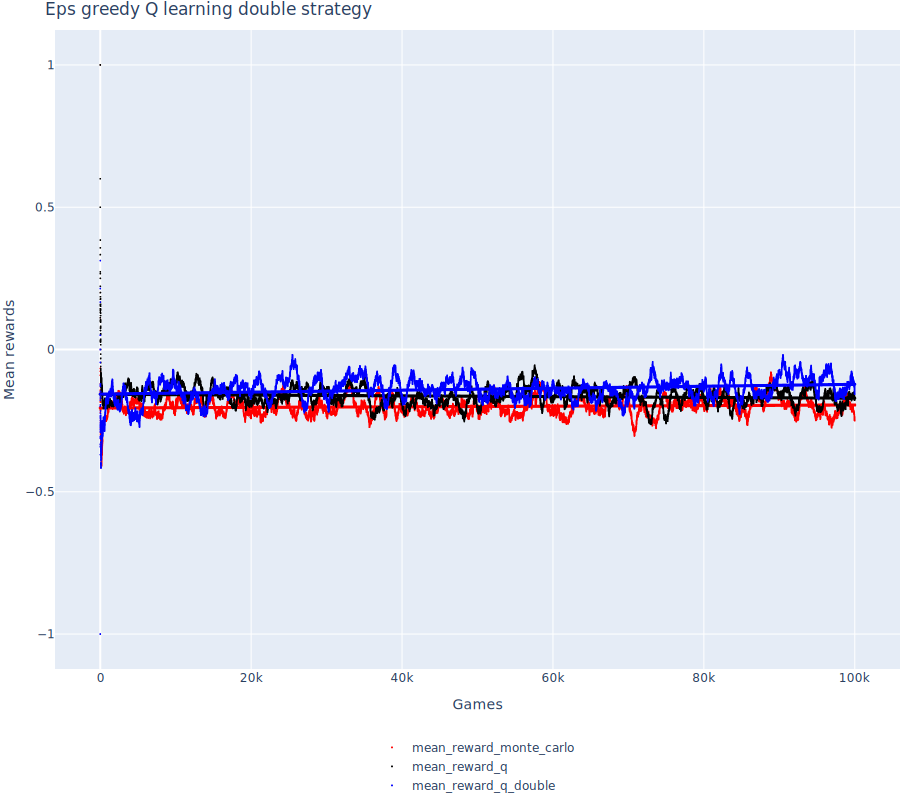

In [183]:
import plotly.graph_objects as go
import pandas as pd

fig3 = px.scatter(mean_reward_q_double, 
                  trendline="ols", 
                  trendline_color_override='blue',
                  trendline_scope='trace', 
                  color_discrete_sequence=['blue'],
                )

fig3.update_traces(mode='markers', marker_size=2)

fig2 = px.scatter(mean_reward_q, 
                  trendline="ols", 
                  trendline_color_override='black',
                  trendline_scope='trace', 
                  color_discrete_sequence=['black'],
                )

fig2.update_traces(mode='markers', marker_size=2)


fig1 = px.scatter(mean_reward_monte_carlo, 
                  trendline="ols", 
                  trendline_color_override='red', 
                  trendline_scope='trace',
                  color_discrete_sequence=['red'],
                )

fig1.update_traces(mode='markers', marker_size=2)


fig = go.Figure(data = fig1.data + fig2.data + fig3.data)

fig.update_traces(
    line=dict(dash="dot", width=4),
    selector=dict(type="scatter", mode="lines"))

line_size = 3
fig.data[1].marker.size=line_size
fig.data[3].marker.size=line_size
fig.data[5].marker.size=line_size

fig.data[0].name="mean_reward_monte_carlo"
fig.data[2].name="mean_reward_q"
fig.data[4].name="mean_reward_q_double"

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Eps greedy Q learning double strategy",
                  xaxis_title="Games",
                  yaxis_title="Mean rewards",
                  margin=dict(l=0, r=0, t=30, b=0))

print(f"Лучшие найденные параметры: (alpha: {best_alpha[0]:.3}, epsilon: {best_epsilon[0]:.3}, gamma: {best_gamma[0]:.3})")

print(f'Количество игр: {N}')
print(f'Средний выигрыш за игру: {np.mean(total_reward_q_double)}')
print(f'Средний выигрыш за игру за первые {K} игр: {total_reward_q_double[K]}')
print(f'Средний выигрыш за игру за последние {K} игр: {total_reward_q_double[-1]}')
print(f'Общий выигрыш за все игры: {np.sum(total_reward_q_double)}')

fig.show(renderer="svg", width=900, height=800)

In [186]:
print(f''' 
Средний выигрыш простой стратегией: {np.mean(total_reward_monte_carlo)}
Средний выигрыш Eps greedy Q learning стратегией: {np.mean(total_reward_q)}
Средний выигрыш Eps greedy Q learning double стратегией: {np.mean(total_reward_q_double)}
''')

 
Средний выигрыш простой стратегией: -0.20015
Средний выигрыш Eps greedy Q learning стратегией: -0.16438
Средний выигрыш Eps greedy Q learning double стратегией: -0.138915



Благодаря исользованию удвоения ставки удалось еще больше снизить проигрыш